### Running an example autoencoder
From: https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
# Starting with only one fully-connected neural layer as encoder and decoder:

from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [26]:
# What about having a separate encoder and decoder?
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))



In [27]:
# Now train on MNIST,
# First using a per-pixel binary crossentropy loss and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [28]:
# Get the data but discared the labels:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [29]:
# Normalize and flatten:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [30]:
# Train the autoencoder for 50 epochs:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.3558 - val_loss: 0.2718
Epoch 2/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2655 - val_loss: 0.2558
Epoch 3/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2451 - val_loss: 0.2313
Epoch 4/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2231 - val_loss: 0.2124
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2071 - val_loss: 0.1989
Epoch 6/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1955 - val_loss: 0.1891
Epoch 7/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.1868 - val_loss: 0.1816
Epoch 8/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1800 - val_loss: 0.1754
Epoch 9/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1743 - val_loss: 0.1701
Epoch

In [31]:
# I think it's optimizing using 'loss'
# Try to visualize the reconstructed inputs and the encoded (middle layer) representation:
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

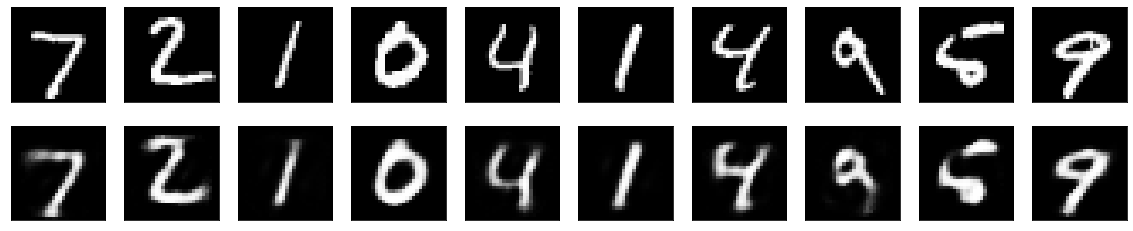

In [32]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### I think this is pretty good but they say that we're losing detail so let's play around

In [34]:
# One way to gain detail is to use a sparsity constraint on the encoded representations
# Previously, the hidden layer had 32 'pixels', which is kinda like a PCA with 32 axes
# Another way to do this is to add a sparsity constraint on the activation of the hidden representations so
# fewer units can fire and contribute. This is done adding an activity_regularizer to the Dense layer:
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model
encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)#was 10e-5
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')



In [35]:
# Regularizers help you avoid overfitting, so you can train the model for longer (100 epochs)
# Train the autoencoder for 50 epochs:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.6728 - val_loss: 0.6484
Epoch 2/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.4531 - val_loss: 0.4457
Epoch

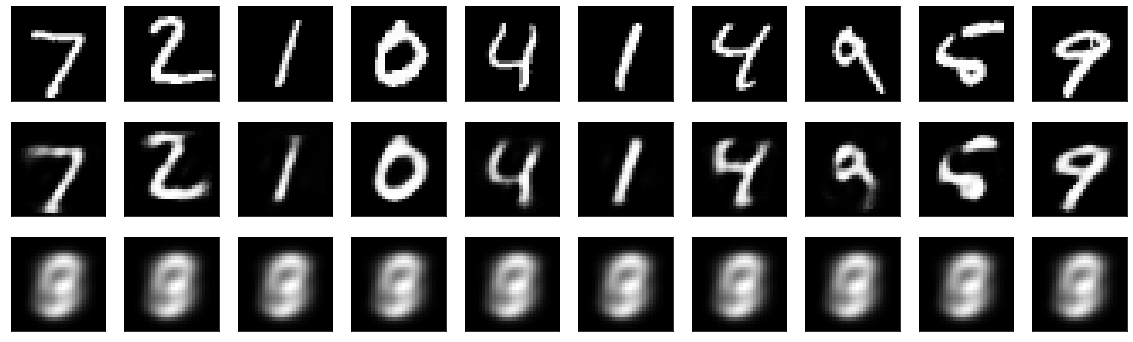

In [36]:
import matplotlib.pyplot as plt
decoded_imgs_reg = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_reg[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [21]:
# Strangely, it seems to be totally broken, we'll move on
# What about adding more layers?

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

'''encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))'''

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.3508 - val_loss: 0.2649
Epoch 2/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.2571 - val_loss: 0.2491
Epoch 3/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.2434 - val_loss: 0.2380
Epoch 4/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.2307 - val_loss: 0.2242
Epoch 5/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.2226 - val_loss: 0.2175
Epoch 6/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.2126 - val_loss: 0.2039
Epoch 7/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.1987 - val_loss: 0.1910
Epoch 8/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1872 - val_loss: 0.1847
Epoch 9/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.1793 - val_loss: 0.1

60000/60000 [==============================] - 4s 64us/step - loss: 0.1070 - val_loss: 0.1076
Epoch 78/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1067 - val_loss: 0.1057
Epoch 79/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1065 - val_loss: 0.1036
Epoch 80/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1062 - val_loss: 0.1058
Epoch 81/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1060 - val_loss: 0.1055
Epoch 82/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1057 - val_loss: 0.1062
Epoch 83/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1056 - val_loss: 0.1039
Epoch 84/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1053 - val_loss: 0.1050
Epoch 85/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1051 - val_loss: 0.1028
Epoch 86/100
60000/60000 [========================

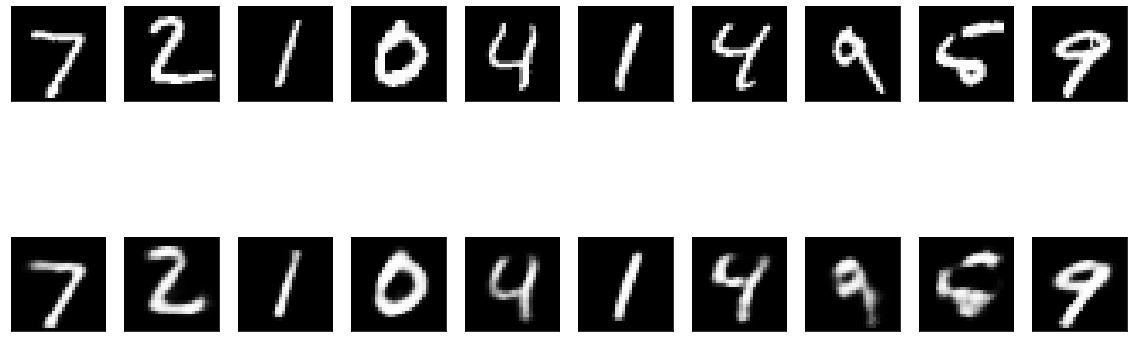

In [23]:
decoded_imgs_deep = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    '''ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)'''
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_deep[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### It makes sense to turn this into a convolution autoencoder because these are images

In [37]:
# This encoder stacks Cov2D and MaxPooling2D layers (max pooling apparently does spatial down-sampling)
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [38]:
# To train it you'll need to reorganize the data so that it's no longer flattened:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [40]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))#,
#                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 77s 1ms/step - loss: 0.1476 - val_loss: 0.1388
Epoch 2/50
60000/60000 [==============================] - 78s 1ms/step - loss: 0.1375 - val_loss: 0.1360
Epoch 3/50
60000/60000 [==============================] - 77s 1ms/step - loss: 0.1311 - val_loss: 0.1291
Epoch 4/50
60000/60000 [==============================] - 78s 1ms/step - loss: 0.1269 - val_loss: 0.1266
Epoch 5/50
60000/60000 [==============================] - 77s 1ms/step - loss: 0.1236 - val_loss: 0.1207
Epoch 6/50
60000/60000 [==============================] - 76s 1ms/step - loss: 0.1210 - val_loss: 0.1158
Epoch 7/50
60000/60000 [==============================] - 76s 1ms/step - loss: 0.1187 - val_loss: 0.1142
Epoch 8/50
60000/60000 [==============================] - 76s 1ms/step - loss: 0.1166 - val_loss: 0.1109
Epoch 9/50
60000/60000 [==============================] - 76s 1ms/step - loss: 0.1154 - val_loss: 0.1119
Epoch

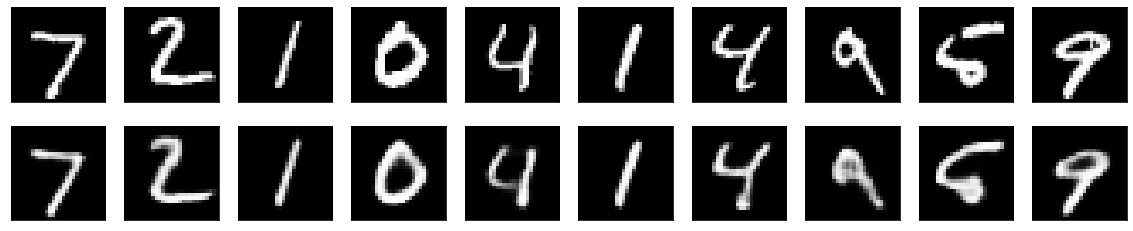

In [42]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Variational autencoder might be good for classification and unsupervised learning
It's an autoencoder with added constraints ont he representations learned. It learns a latent variable model 
instead of an arbitrary function. It's a generative model

In [22]:
#from: https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

'''plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")'''

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_24[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_24[0][0]                   
____________________________________________________________________________________________

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 162us/step - loss: 195.8669 - val_loss: 171.3128
Epoch 2/50
60000/60000 [==============================] - 9s 143us/step - loss: 168.2301 - val_loss: 166.2867
Epoch 3/50
60000/60000 [==============================] - 9s 143us/step - loss: 164.7584 - val_loss: 163.8811
Epoch 4/50
60000/60000 [==============================] - 9s 144us/step - loss: 162.7225 - val_loss: 162.0161
Epoch 5/50
60000/60000 [==============================] - 9s 148us/step - loss: 161.1359 - val_loss: 160.6948
Epoch 6/50
60000/60000 [==============================] - 9s 144us/step - loss: 159.7055 - val_loss: 159.5209
Epoch 7/50
60000/60000 [==============================] - 9s 144us/step - loss: 158.4370 - val_loss: 158.2682
Epoch 8/50
60000/60000 [==============================] - 9s 147us/step - loss: 157.2599 - val_loss: 157.2834
Epoch 9/50
60000/60000 [==============================] - 9s 146us/st

NameError: name 'models' is not defined

In [12]:
batch_size = 128
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [13]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [14]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [18]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50


InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype float and shape [128,784]
	 [[{{node input_3}}]]

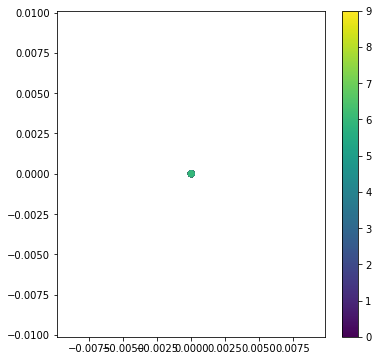

NameError: name 'epsilon_std' is not defined

In [24]:
x_test_encoded = vae.predict(x_test, batch_size=batch_size)# could try vae.predict
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()